# Importing Necessary Modules

##### *Split-Folders* is a library designed to split data into **Train,Test,Validation** from a directory.
##### This transformed dataset is saved in **/kaggle/working/output/** directory.

In [ ]:
#Installing the required package

!pip install split-folders

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pathlib
import random
import os
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

#Suppressing Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Loading DataSet

In [ ]:
data_dir = "../input/pistachio-image-dataset/Pistachio_Image_Dataset/Pistachio_Image_Dataset/"

#### We are splitting the dataset in the following format:

* 80% Training
* 10% Validation
* 10% Test

In [ ]:
splitfolders.ratio(data_dir, output="output", seed=101, ratio=(.8, .1, .1))

Copying files: 2148 files [00:10, 199.26 files/s]


#### New paths that we will use for Data Augmentation and Displaying Images

In [ ]:
train_path = './output/train'
test_path = './output/test'
val_path = './output/val'

# Image Preprocessing

Notice the path I've passed for images.
Here I am displaying the size of the original images to see if resizing is required or not.

In [ ]:
img = mpimg.imread('./output/train/Kirmizi_Pistachio/kirmizi 62.jpg')
img1 = mpimg.imread('./output/train/Siirt_Pistachio/siirt 603.jpg')

In [ ]:
img.shape, img1.shape

((600, 600, 3), (600, 600, 3))

Our original images have a size of **(600,600)** so we will be using 512 as the image size to keep the size as a multiple of 64.
We could use resizing further but since our dataset is small, we will not be resizing it a lot and using 512 for our purpose.

In [ ]:
img_size = 512
batch = 16

In [ ]:
labels = []
for i in os.listdir(train_path):
    labels+=[i]

In [ ]:
labels

['Siirt_Pistachio', 'Kirmizi_Pistachio']

# Displaying Images

In [ ]:
def load_random_imgs_from_folder(folder,label):
  plt.figure(figsize=(15,15))
  for i in range(3):
    file = random.choice(os.listdir(folder))
    image_path = os.path.join(folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,3,i+1)
    ax.title.set_text(label)
    plt.xlabel(f'Name: {file}')
    plt.imshow(img)

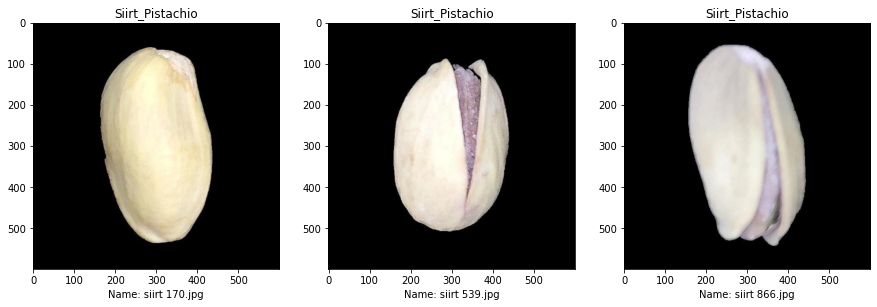

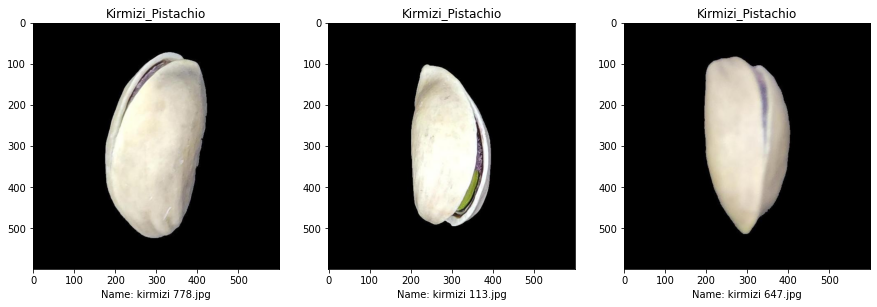

In [ ]:
for label in labels:
    load_random_imgs_from_folder(f"{data_dir}/{label}",label)

# Image Augmentation

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   rotation_range = 0.5,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest'
                                  )

test_val_datagen = ImageDataGenerator(rescale = 1.0/255.0)

In [ ]:
train_generator = train_datagen.flow_from_directory(directory = train_path,
                                                    batch_size = batch,
                                                    class_mode = "categorical",
                                                    target_size = (img_size,img_size)
                                                    )

val_generator = test_val_datagen.flow_from_directory(directory = val_path,
                                                    batch_size = batch,
                                                    class_mode = "categorical",
                                                    target_size = (img_size,img_size)
                                                    )

test_generator = test_val_datagen.flow_from_directory(directory = test_path,
                                                    batch_size = batch,
                                                    class_mode = "categorical",
                                                    target_size = (img_size,img_size)
                                                    )

Found 1717 images belonging to 2 classes.
Found 214 images belonging to 2 classes.
Found 217 images belonging to 2 classes.


In [ ]:
data_train = image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=0,
    color_mode="rgb",
    image_size=(img_size,img_size),
    batch_size=32,
)
data_test = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=0,
    color_mode="rgb",
    image_size=(img_size,img_size),
    batch_size=32,
)

Found 2148 files belonging to 2 classes.
Using 1719 files for training.
Found 2148 files belonging to 2 classes.
Using 429 files for validation.


In [ ]:
# # small train dataset with BATCH_SIZE*SMALL_DATASET_BATCHES images
# train_data_small = data_train.take(2)

# Modelling

### I have used Transfer Learning using a pre-trained VGG16 Model

In [ ]:
from keras.applications.efficientnet import EfficientNetB6

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False,
                            input_shape=(img_size, img_size,3))

# freeze extraction layers
base_model.trainable = False

# add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(4096,activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(4096,activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2096,activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2096,activation="relu")(x)
x = Dropout(0.4)(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# confirm unfrozen layers
for layer in model.layers:
    if layer.trainable==True:
        print(layer)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# model.summary()

### Visual Representation of the model layers

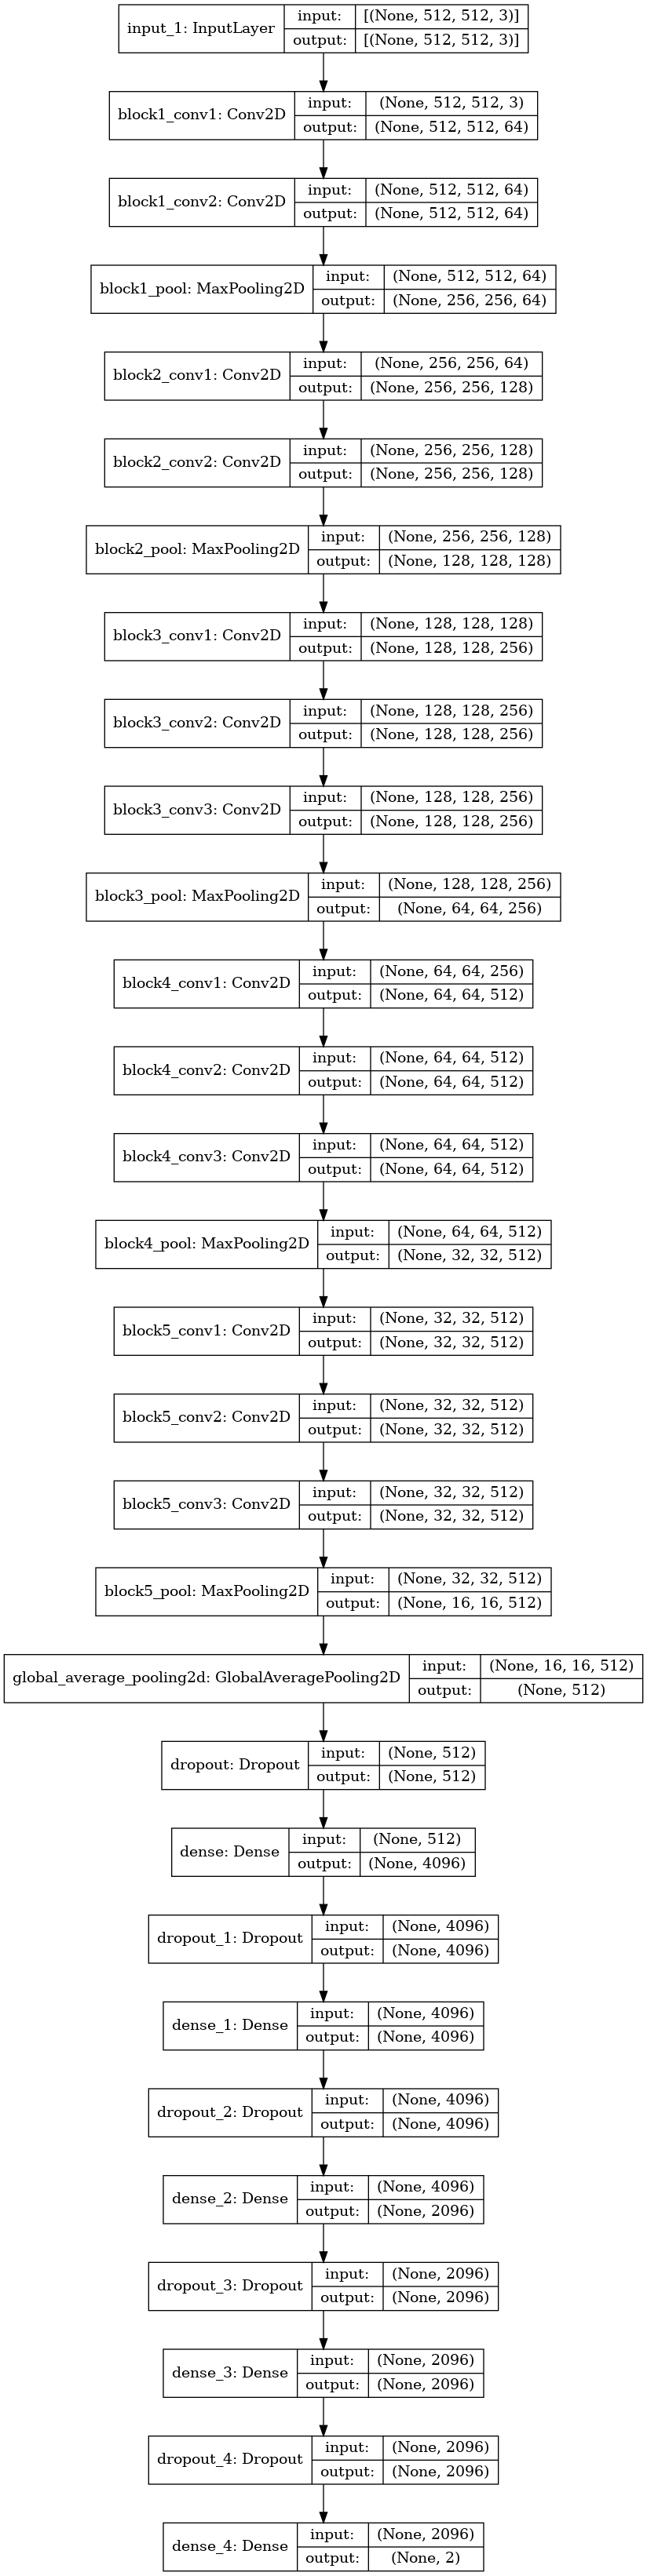

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

### Callback to continually monitor the validation loss and stop the training of model when it overfits

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
                ModelCheckpoint('model.hdf5',
                                 save_best_only=True)]

In [ ]:
opt = Adam(learning_rate=0.0001)
model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)

# Training of Model

### Reason for 50 epochs is that if the model begins to overfit or the validation loss does not decrease much then callback will automatically stop the training

In [ ]:
history=model.fit(data_train,
                  epochs=50,
                  validation_data=data_test,
                  validation_steps=int(0.1 * len(data_test)),
                  verbose=1,
                  callbacks=callbacks)

Epoch 1/50
54/54 [==============================] - 48s 581ms/step - loss: 0.5055 - accuracy: 0.7504 - val_loss: 0.2015 - val_accuracy: 0.8750
Epoch 2/50
54/54 [==============================] - 23s 397ms/step - loss: 0.3108 - accuracy: 0.8720 - val_loss: 0.1047 - val_accuracy: 0.9688
Epoch 3/50
54/54 [==============================] - 23s 408ms/step - loss: 0.2530 - accuracy: 0.8947 - val_loss: 0.2778 - val_accuracy: 0.8438
Epoch 4/50
54/54 [==============================] - 23s 410ms/step - loss: 0.2283 - accuracy: 0.9052 - val_loss: 0.2498 - val_accuracy: 0.8750
Epoch 5/50
54/54 [==============================] - 23s 408ms/step - loss: 0.1654 - accuracy: 0.9302 - val_loss: 0.0533 - val_accuracy: 1.0000
Epoch 6/50
54/54 [==============================] - 23s 404ms/step - loss: 0.1828 - accuracy: 0.9261 - val_loss: 0.0875 - val_accuracy: 0.9688
Epoch 7/50
54/54 [==============================] - 23s 401ms/step - loss: 0.1818 - accuracy: 0.9267 - val_loss: 0.1715 - val_accuracy: 0.9375

### This is the code for training on augmented data but I tried and the model was stuck at 57% training accuracy before callback was hit so I decided to first test on unaugmented data and then generate a new model for augmentation.

In [ ]:
# history = model.fit(train_generator,
#                     epochs = 50,
#                     validation_data = val_generator,
#                     verbose = 1,
#                    callbacks=callbacks)

# Model Evaluation

In [ ]:
from tensorflow.keras.models import load_model

### Loading Best Model Saved during Callback

In [ ]:
model = load_model('./model.hdf5')

In [ ]:
def learning_curve(model_fit, key='accuracy', ylim=(0, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'val'], loc='best')
    plt.show()

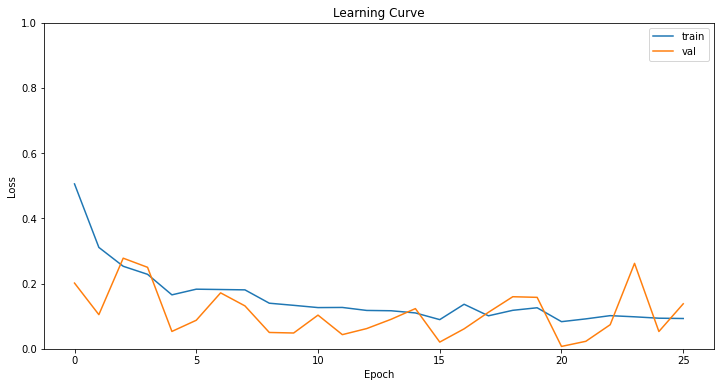

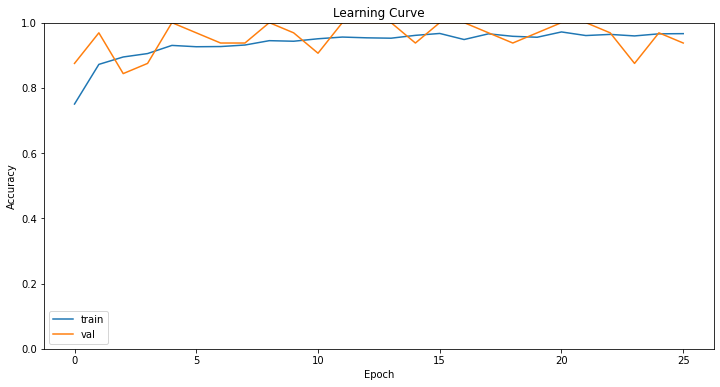

In [ ]:
learning_curve(history,'loss', ylim=(0,1))
learning_curve(history, 'accuracy', ylim=(0,1))

In [ ]:
test_loss, test_acc = model.evaluate(data_test, steps=len(data_test), verbose=1)
print('Loss: %.3f' % (test_loss))
print('Accuracy: %.3f' % (test_acc * 100.0))

14/14 [==============================] - 12s 759ms/step - loss: 0.0696 - accuracy: 0.9814
Loss: 0.070
Accuracy: 98.135


In [ ]:
predictions = np.array([])
labels =  np.array([])
for x, y in data_test:
    predictions = np.concatenate([predictions, np.argmax(model.predict(x),axis=1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

In [ ]:
classes = []
for i in os.listdir(train_path):
    classes+=[i]

classes

['Siirt_Pistachio', 'Kirmizi_Pistachio']

### Function for calculating F1-Score

In [ ]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta_squared = 4

    y_pred = K.clip(y_pred, 0, 1)

    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

### Function for plotting Confusion Matrix

In [ ]:
def confusion_matrix_plot(matrix):
    plt.figure(figsize=(12,10))
    cmap = "YlGnBu"
    ax= plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=cmap);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    plt.savefig('/kaggle/working/img1.png')
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels');
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(classes);
    ax.yaxis.set_ticklabels(classes[::-1]);
    plt.show()

### Function for Calculating Classification Report and other metrics

In [ ]:
def cal_score(model, key):
    matrix = confusion_matrix(predictions, labels)
    print(matrix)
    print('\n')

    f1 = f1_score(predictions, labels, average='weighted')
    print(f'F1 Score: {f1}')
    print('\n')

    print(classification_report(predictions, labels, target_names=classes))

    if key==1:
        confusion_matrix_plot(matrix)

[[236   4]
 [  4 185]]


F1 Score: 0.9813519813519813


                   precision    recall  f1-score   support

  Siirt_Pistachio       0.98      0.98      0.98       240
Kirmizi_Pistachio       0.98      0.98      0.98       189

         accuracy                           0.98       429
        macro avg       0.98      0.98      0.98       429
     weighted avg       0.98      0.98      0.98       429



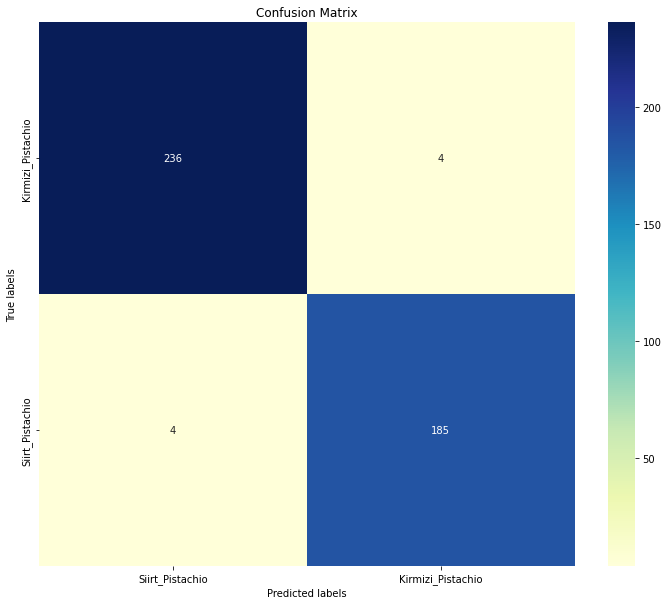

In [ ]:
cal_score(model, 1)

In [ ]:
# test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
# print('Loss: %.3f' % (test_loss * 100.0))
# print('Accuracy: %.3f' % (test_acc * 100.0))